### Homework 2: Graph Neural Networks

- Author: Ludek Cizinsky (`ludek.cizinsky@epfl.ch`)

### Notebeook setup

#### Jupyter notebook utils

In [1]:
%load_ext autoreload
%autoreload 2

#### Experiment logging (optional)

In [2]:
LOGEXP = True # This enables w&b logging
if LOGEXP:
    import wandb
    import os
    os.environ["WANDB_NOTEBOOK_NAME"] = "run.ipynb"

#### Dependencies import

In [3]:
# Hugging face util to download dataset
from datasets import load_dataset

# Scikit-learn
from sklearn.model_selection import train_test_split

# PyTorch
import torch
from torch import nn
# - Dataloader
from torch.utils.data import Dataset, DataLoader
# - Optimization
from torch.optim import Adam, SGD
# - Loss
from torch.nn import BCELoss, BCEWithLogitsLoss

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Custom scripts
from scripts.dataset import GraphDataset
from scripts.layers import (
    # Normal
    GraphConv,
    # Graph Sage
    GraphSAGEConv,
    MeanAggregation,
    # Graph Attention
    GraphAttentionConv,
    # Pooling
    MeanPool,
    MaxPool,
)

from scripts.architecture import (
    GNN
)

from scripts.utils import (
    train_and_evaluate,
    plot_losses_and_f1s,
    evaluate,
)

/Users/ludekcizinsky/miniconda3/envs/cs502/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Reproducibility

In [4]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(hash("GNNs") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("are cool") % 2**32 - 1)

### Load the dataset

Some important notes:

- the dataset includes collection of chemical compounds represented as graphs (details are specified below), i.e., one sample is a graph and we have a corresponding ground truth label indicating whether the compound is mutagenic or not
- On the lower level, each node has associated embedding (one hot encoding) indicating its type, same goes for the edges, **the dimensions of these embeddings are different**

#### Download the dataset from Hugging Face (HF)

In [5]:
dataset_hf = load_dataset("graphs-datasets/MUTAG")['train']

#### Train, validation and test split

In [6]:
# Parse the dataset into X and y
X, y = [], []
for s in dataset_hf:
    X.append(s)
    y.extend(s['y'])

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Load it using custom dataloader

In [7]:
# Define hyperparameters for the dataloader
batch_size = 64
shuffle = False

# Define custom stacking behavior for the dataloader
def collate_fn(batch):
    inputs, labels = [], []
    
    for item in batch:
        input_dict, label = item
        inputs.append(input_dict)
        labels.append(label)
    
    # Convert the list of labels to a 1D tensor
    labels = torch.tensor(labels).view(-1).type(torch.FloatTensor)
    
    return inputs, labels

# Define custom datasets
train_dataset = GraphDataset(X_train, y_train)
val_dataset = GraphDataset(X_val, y_val)
test_dataset = GraphDataset(X_test, y_test)

# Define custom dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=shuffle,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=shuffle,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=shuffle,
    collate_fn=collate_fn
)

### Implementation of different graph and convolution and pooling layers

See the [layers.py file](scripts/layers.py) for the implementation details.

### Custom Network Design with Node Features

Train F1 (macro),▁▁▁▁▅▅▇▇████████████████████████████████
Train Loss,██▇▇▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation F1 (macro),▁▁▁▁▄▅▇▇▇▇▇▇▇▇▇▇████████████████████████
Validation Loss,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train F1 (macro),0.81576
Train Loss,0.64261
Validation F1 (macro),0.82857
Validation Loss,0.37921


Epoch [1/200](0.21s) Train Loss: 1.0893 Train F1(macro): 0.41% Validation Loss: 0.5948 Validation F1(macro): 0.36%
Epoch [2/200](0.16s) Train Loss: 1.0704 Train F1(macro): 0.41% Validation Loss: 0.6187 Validation F1(macro): 0.36%
Epoch [3/200](0.19s) Train Loss: 1.0743 Train F1(macro): 0.41% Validation Loss: 0.6223 Validation F1(macro): 0.36%
Epoch [4/200](0.16s) Train Loss: 1.0715 Train F1(macro): 0.41% Validation Loss: 0.6096 Validation F1(macro): 0.36%
Epoch [5/200](0.16s) Train Loss: 1.0646 Train F1(macro): 0.41% Validation Loss: 0.5947 Validation F1(macro): 0.36%
Epoch [6/200](0.16s) Train Loss: 1.0616 Train F1(macro): 0.41% Validation Loss: 0.5855 Validation F1(macro): 0.36%
Epoch [7/200](0.18s) Train Loss: 1.0621 Train F1(macro): 0.41% Validation Loss: 0.5834 Validation F1(macro): 0.36%
Epoch [8/200](0.16s) Train Loss: 1.0615 Train F1(macro): 0.41% Validation Loss: 0.5867 Validation F1(macro): 0.36%
Epoch [9/200](0.18s) Train Loss: 1.0591 Train F1(macro): 0.41% Validation Loss: 

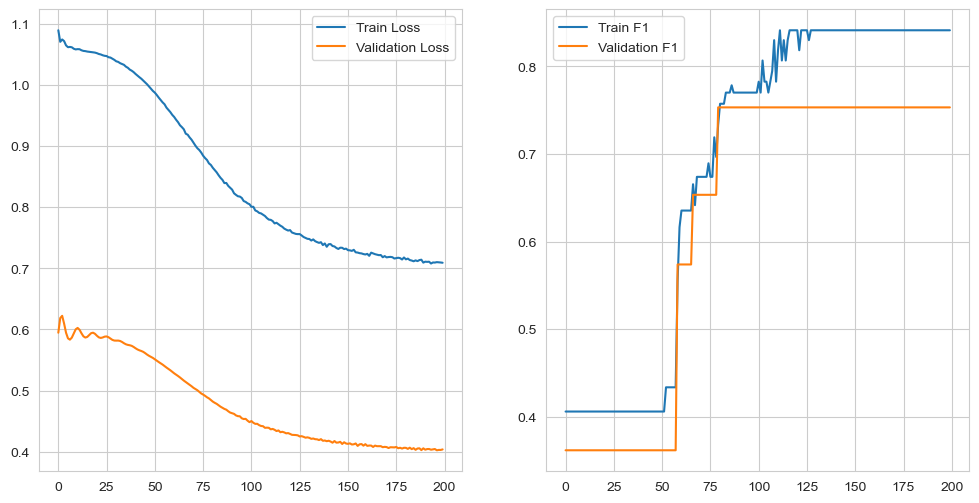

wandb: Network error (ConnectionError), entering retry loop.


In [11]:
# Define the model's architecture hyper-parameters
num_features = len(X_train[0]['node_feat'][0])
activation = nn.LeakyReLU()
pooling = MeanPool()
aggregation = MeanAggregation()
dropout = 0.001

# Define the model's architecture
architecture = [
    [GraphAttentionConv, {'in_features': num_features, 'out_features': 64}],
    [GraphAttentionConv, {'in_features': 64, 'out_features': 32}],
]

# Define the model
model = GNN(architecture, pooling, dropout=dropout)

# Increase the precision of the model
model = model.double()

# Define traininglhyperparameters
lr = 1e-2
wd = 1e-3
epochs = 200
pos_weight = 0.7
criterion = BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
# optimizer = SGD(model.parameters(), lr=lr)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

# Log the setup of the experiment
if LOGEXP:
    # track hyperparameters and run metadata
    config = ( 
        {
            "learning_rate": lr,
            "architecture": "Graph Attention Convolutional Network - 2 layers",
            "dataset": "MUTAG",
            "epochs": epochs,
            "batch_size": batch_size,
            "optimizer": str(optimizer),
            "shuffle": shuffle,
            "activation": str(activation),
            "pooling": str(pooling),
            "aggregation": str(aggregation),
            "dropout": dropout,
            "weight_decay": wd,
            "pos_weight": pos_weight,
        }
    )
else:
    config = None

# Train the model
train_losses, val_losses, train_accs, val_accs = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs, config)

# Visualise the results
fig = plot_losses_and_f1s(train_losses, val_losses, train_accs, val_accs)